In [1]:
import os
import re
import json
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy import stats
from statsmodels.stats import weightstats 
from matplotlib.lines import Line2D

# Catawba [05/22]


In [2]:
# Load catawba manual data
mandf0 = pd.read_excel("../data/manual/05_2022/validation_man.xlsx")

# Assume flat ground 
# Use the angle(θ) and distance from the base of the tree (d) to calculate tree height (h)

# Convert slope (%) to radians
mandf0['angle_rad'] = np.arctan(mandf0['angle']*0.01)

# angle in degrees
mandf0['angle_deg'] = np.rad2deg(mandf0['angle_rad'])

# compute tree height = tan(θ) * distance (d) + viewer height 
mandf0['height_ft'] = np.tan(mandf0['angle_rad']) * mandf0['distance'] + 5.375 # John height = 64.5 in == 5.375 ft

# Convert ft --> in 
mandf0['height'] = mandf0['height_ft'] * 12.

# Fill in the tree heights that were measured without clinometer (shorties)
mandf0['height'][np.isnan(mandf0['height_ft'])] = mandf0['height_in']

# inches to cm
mandf0['diam'] = mandf0['diam']*2.54
mandf0['height'] = mandf0['height']*2.54

# add col with measurement approaches 
mandf0['method'] = 'manual_0'

# add col with site 
mandf0['site'] = 'catawba'


/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7844/2147539998.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandf0['height'][np.isnan(mandf0['height_ft'])] = mandf0['height_in']


In [3]:
# Read db dump
measurements = []
for line in open('../data/app/05_2022/bquxjob_4eb29efb_180f7d82eb2.json', 'r'):
    measurements.append(json.loads(line))

In [4]:
# extract the relevant info 
outrows = []
for idx,tree in enumerate(measurements):
    diam = float(measurements[idx]['diameter']['value']) * 2.54 # in to cm
    height = float(measurements[idx]['height']['value']) * 2.54 # in to cm
    unit = measurements[idx]['height']['unit']
    species = measurements[idx]['speciesName']
    date = measurements[idx]['captureDate']
    parcel = measurements[idx]['parcelId']
    lat = measurements[idx]['lat']
    lon = measurements[idx]['long']
    tree_id = measurements[idx]['id']
    diam_url = measurements[idx]['photos'][0]['url']
    height_url = measurements[idx]['photos'][1]['url']

    treedf = pd.DataFrame([date,lat,lon,tree_id,diam,height,species,height_url, diam_url,parcel]).T
    treedf.columns = ['date','lat','lon','tree_id','diam','height','species','height_url', 'diam_url','parcel_id']
    outrows.append(treedf)
    
# concat 
valdf = pd.concat(outrows, axis = 0)
valdf['date'] = pd.to_datetime(valdf['date'])
valdf = valdf.sort_values(by='date', ascending = True)

# Isolate field campaign dates
mask = (valdf['date'] >= "2022-05-12") & (valdf['date'] <= '2022-05-14')
appdf = valdf[mask]
appdf = appdf.sort_values(by='date', ascending = True)[1:]
pid = list(appdf['parcel_id'])[0]
appdf['parcel_id'] = pid

In [5]:
mask = (valdf['date'] >= "2022-05-12") & (valdf['date'] <= '2022-05-14')
appdf = valdf[mask]
appdf = appdf.sort_values(by='date', ascending = True)[1:]
pid = list(appdf['parcel_id'])[0]
appdf['parcel_id'] = pid

In [6]:
compdf = pd.merge(appdf, mandf0, on = 'tree_id')
compdf.rename(columns = {'diam_x':'diam_app', 'diam_y':'diam', 'height_x':'height_app', 'height_y':'height'}, inplace = True)

In [7]:
compdf.to_csv("../data/catawba_05_22.csv")

# Kentland [10/22]


In [8]:
# Load the manual dataframes
mandf1 = pd.read_excel("../data/manual/10_2022/Working Tree Kentland 2022_SP.xlsx", sheet_name = "Kentland 1")
mandf2 = pd.read_excel("../data/manual/10_2022/Working Tree Kentland 2022_SP.xlsx", sheet_name = "Kentland 2")

# ft --> inches 
mandf1['height_1'] = mandf1['Height (ft)'] * 12
mandf2['height_2'] = mandf2['Height (ft)'] * 12
mandf1['diam_1'] = mandf1["DBH (In)"] * 2.54 # in to cm
mandf2['diam_2'] = mandf2["DBH (In)"] * 2.54 # in to cm

# add col with measurement approaches 
mandf1['method'] = 'manual 1'
mandf2['method'] = 'manual 2'

# add col with site 
mandf2['site'] = 'kentland'
mandf1['site'] = 'kentland'

mandf1_clean = mandf1.drop(["Height (ft)", "DBH (In)"], axis = 1)
mandf2_clean = mandf2.drop(["Height (ft)", "DBH (In)"], axis = 1)

# Merge back
manual_10_22= pd.merge(mandf1_clean, mandf2_clean, right_on=['Row#','Tree#'], left_on = ['Row#','Tree#'], how='outer')
manual_10_22['height_mean'] = manual_10_22[['height_1','height_2']].mean(axis = 1)
manual_10_22['diam_mean'] = manual_10_22[['diam_1','diam_2']].mean(axis = 1)


In [9]:
# Load app sampling datasets and do lots of formatting
# Read db dump
measurements = []
for line in open('../data/app/10_2022/validation_10_2022.json', 'r'):
    measurements.append(json.loads(line))

# Extract trees line by line

outrows = []

for idx,tree in enumerate(measurements):
    try:
        diam = measurements[idx]['diameter']['value']
        height = measurements[idx]['height']['value']
        unit = measurements[idx]['height']['unit']
        species = measurements[idx]['speciesName']
        date = measurements[idx]['captureDate']
        parcel = measurements[idx]['parcelId']
        lat = measurements[idx]['lat']
        lon = measurements[idx]['long']
        tree_id = measurements[idx]['id']
        diam_url = measurements[idx]['photos'][0]['url']
        height_url = measurements[idx]['photos'][1]['url']
        notes = measurements[idx]['notes']

        treedf = pd.DataFrame([date,lat,lon,tree_id,diam,height,species,height_url, diam_url,parcel, notes]).T
        treedf.columns = ['date','lat','lon','tree_id','diam','height','species','height_url', 'diam_url','parcel_id','notes']
        outrows.append(treedf)
        
    except:
        continue
    
    
# concat 
valdf = pd.concat(outrows, axis = 0)
valdf['date'] = pd.to_datetime(valdf['date'])
valdf = valdf.sort_values(by='date', ascending = True)

# Filter out parcels with a single measurement - this leaves just Sanjok x2 and Brenda 
valdf = pd.concat(outrows, axis = 0)
valdf['date'] = pd.to_datetime(valdf['date'])
valdf = valdf.sort_values(by='date', ascending = True)
# Count n rows in each parcel 
valdf['parcel_id'].value_counts()
# record 
counts = valdf['parcel_id'].value_counts(dropna=False) 
valids = counts[counts>1].index
# filter 
appdf = valdf[valdf['parcel_id'].isin(valids)]
# Extract the indices for each tree

notescol = list(appdf['notes'])

rows = []
cols = []

for x in notescol:
    xstr = x.lower()
    rows.append(re.sub('[^0-9]','', xstr.split("p")[0]))
    cols.append(re.sub('[^0-9]','', xstr.split("p")[1]))

# Apply indices  
appdf['row'] = rows
appdf['tree_idx'] = cols

appdf['row'] = appdf['row'].astype(float)
appdf['tree_idx'] = appdf['tree_idx'].astype(float)
appdf['diam'] = appdf['diam'].astype(float) * 2.54 # in to cm
appdf['height'] = appdf['height'].astype(float) * 2.54 # in to cm 
appdf['lat'] = appdf['lat'].astype(float)
appdf['lon'] = appdf['lon'].astype(float)

appdf.replace({'parcel_id':{'5F2EA33C-65AD-4826-BF5C-D585E410C877':'User 1',
                           'A57E7C65-8B5C-43B2-9110-5A6A4ECFBC35':'User 1 repeat',
                           '48A3274A-5E61-4644-8C5E-0E856E87AF4F':'User 2'}}, inplace = True)
    


/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7844/4176127585.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appdf['row'] = rows
/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7844/4176127585.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appdf['tree_idx'] = cols
/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7844/4176127585.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [10]:
tdfs = []

# For each tree (unique row / col combo index), calculate mean and variance for errorbar plots 
for ridx in appdf['row'].unique():
    ardf = appdf[appdf['row']==ridx]
    mrdf = manual_10_22[manual_10_22['Row#'] == ridx]
    for tidx in appdf['tree_idx'].unique():
        atdf = ardf[ardf['tree_idx'] == tidx]
        mtdf = mrdf[mrdf['Tree#'] == tidx]
        if len(atdf) > 0 and len(mtdf) > 0:
            app_tree_df = pd.DataFrame([atdf['diam'].mean(),atdf['diam'].std(), len(atdf['diam'])]).T
            man_tree_df = pd.DataFrame([mtdf[['diam_1','diam_2']].values.mean(),mtdf[['diam_1','diam_2']].values.std(), len(mtdf[['diam_1','diam_2']].values), mtdf['SN_x'].iloc[0],mtdf['Species_x'].iloc[0]]).T
            app_tree_df.columns = ['app mean','app var','app n']
            man_tree_df.columns = ['man mean','man var','man n', 'tree idx', 'species']
            
            odf = pd.concat([app_tree_df,man_tree_df], axis = 1)
            
            tdfs.append(odf)

In [11]:
appdf_mean = pd.concat(tdfs).reset_index().drop("index", axis = 1).dropna()


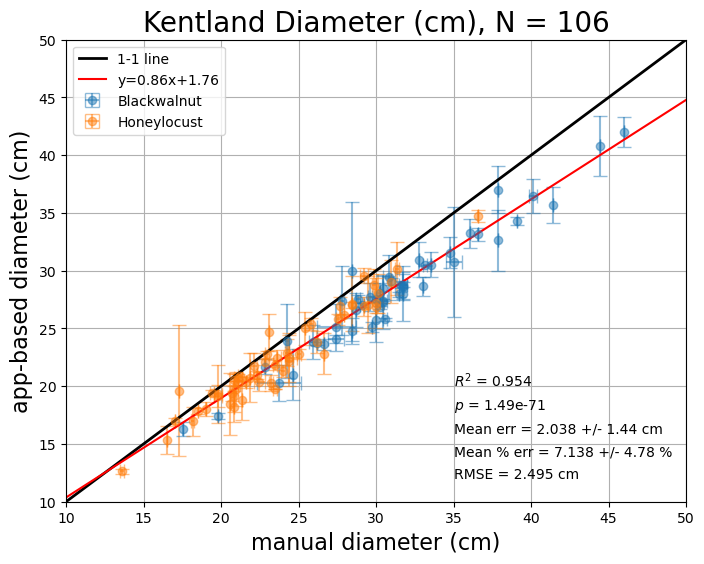

In [12]:

groups = appdf_mean.groupby('species')

# Plot
fig, ax = plt.subplots(figsize = (8,6))

for name, group in groups:
    ax.errorbar(group['man mean'],
             group['app mean'],
             yerr=group['app var'], 
             xerr = group['man var'], 
             linestyle="None", marker='o',capsize=5, label=name, markersize = 6, alpha = 0.5)
    
# Plot 1-1 line
ax.plot([0,300],[0,300],'k-', lw=2, label = '1-1 line')

# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(appdf_mean['man mean'].astype(float), appdf_mean['app mean'])

# Mean absolute error
mae = np.nanmean((appdf_mean['man mean'] - appdf_mean['app mean']))
mae_std = np.nanstd((appdf_mean['man mean'] - appdf_mean['app mean']))
mape = np.nanmean(((appdf_mean['man mean'] - appdf_mean['app mean']) / appdf_mean['man mean'])) * 100
mape_std = np.nanstd(((appdf_mean['man mean'] - appdf_mean['app mean']) / appdf_mean['man mean'])) * 100
rmse = ((appdf_mean['man mean'] - appdf_mean['app mean']) ** 2).mean() ** .5

# regression line 
line = slope*np.linspace(0,300)+ intercept
plt.plot(np.linspace(0,300), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.annotate("$R^2$ = {}".format(str(r_value**2)[:5]), [35,20])
plt.annotate("$p$ = {:.2e}".format(p_value), [35,18])
plt.annotate("Mean err = {} +/- {} cm".format(str(round(mae,5))[:5],str(round(mae_std,2))), [35,16])
plt.annotate("Mean % err = {} +/- {} %".format(str(round(mape,5))[:5],str(round(mape_std,2))), [35,14])
plt.annotate("RMSE = {} cm".format(str(round(rmse,5))[:5],), [35,12])

ax.legend()
ax.set_xlim(10,50)
ax.set_ylim(10,50)
    
plt.xlabel("manual diameter (cm)", size = 16)
plt.ylabel("app-based diameter (cm)", size = 16)


titlestr = "Kentland Diameter (cm), N = {}".format(str(len(appdf_mean)))
plt.title(titlestr, size = 20)
plt.grid()
plt.show()

In [13]:
# Load the manual dataframes
mandf1 = pd.read_excel("../data/manual/10_2022/Working Tree Kentland 2022_SP.xlsx", sheet_name = "Kentland 1")
mandf2 = pd.read_excel("../data/manual/10_2022/Working Tree Kentland 2022_SP.xlsx", sheet_name = "Kentland 2")

# ft --> inches 
mandf1['height_1'] = mandf1['Height (ft)'] * 12
mandf2['height_2'] = mandf2['Height (ft)'] * 12
mandf1['diam_1'] = mandf1["DBH (In)"] * 2.54 # in to cm
mandf2['diam_2'] = mandf2["DBH (In)"] * 2.54 # in to cm

# add col with measurement approaches 
mandf2['method'] = 'manual 2'
mandf1['method'] = 'manual 1'

# add col with site 
mandf2['site'] = 'kentland'
mandf1['site'] = 'kentland'

mandf1_clean = mandf1.drop(["Height (ft)", "DBH (In)"], axis = 1)
mandf2_clean = mandf2.drop(["Height (ft)", "DBH (In)"], axis = 1)

# Merge back
manual_10_22= pd.merge(mandf1_clean, mandf2_clean, right_on=['Row#','Tree#'], left_on = ['Row#','Tree#'], how='outer')
manual_10_22['height_mean'] = manual_10_22[['height_1','height_2']].mean(axis = 1)
manual_10_22['diam_mean'] = manual_10_22[['diam_1','diam_2']].mean(axis = 1)

# Filtering of app data 
appdf.loc[appdf["species"] == 'Black Locust', 'species'] = "Black Walnut"
appdf.loc[appdf["species"] == 'Honey locust', 'species'] = "Honey Locust"
appdf.rename(columns = {"parcel_id":"user"}, inplace = True)

data1 = pd.DataFrame(appdf[appdf['user']=='User 1'][['diam','user','species']])
data2 = pd.DataFrame(appdf[appdf['user']=='User 1 repeat'][['diam','user','species']])
data3 = pd.DataFrame(appdf[appdf['user']=='User 2'][['diam','user','species']])

# Filtering of manual data 
manual_10_22.loc[manual_10_22["Species_x"] == 'Honeylocust', 'species'] = "Honey Locust"
manual_10_22.loc[manual_10_22["Species_x"] == 'Blackwalnut', 'species'] = "Black Walnut"
manual_10_22.loc[manual_10_22["Species_y"] == 'Blackwalnut', 'species'] = "Black Walnut"
manual_10_22.loc[manual_10_22["Species_y"] == 'Blackwalnut', 'species'] = "Black Walnut"
manual_10_22.loc[manual_10_22["method_x"] == 'manual 1', 'method'] = "manual 1"
manual_10_22.loc[manual_10_22["method_y"] == 'manual 2', 'method'] = "manual 2"
# manual_10_22.rename(columns = {'method_x':'user', 'method_y':'user'}, inplace = True)

m1 = manual_10_22[['diam_1','method_x','species']].rename(columns = {'diam_1':'diam','method_x':'user'})
m2 = manual_10_22[['diam_2','method_y','species']].rename(columns = {'diam_2':'diam','method_y':'user'})
# m2['user'] = 'manual 2'

cdf = pd.concat([data1, data2, data3,m1,m2])    
# mdf = pd.melt(cdf, id_vars=['species'], var_name=['user'])


/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


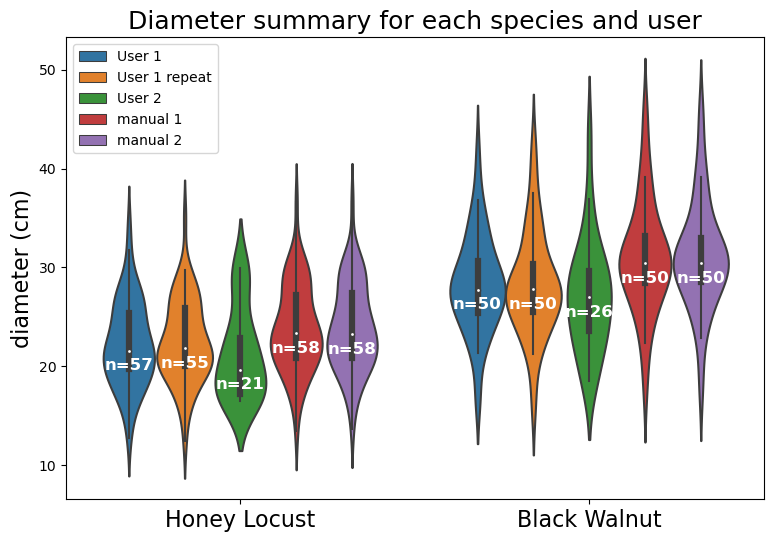

In [14]:
fig, ax = plt.subplots(figsize = (9,6))
ax = sns.violinplot(x="species", y="diam", hue="user", data=cdf)

medians = cdf.groupby(['user','species'])['diam'].median()
nobs =  cdf.groupby(['user','species']).apply(lambda x: 'n={}'.format(len(x)))

for ax in plt.gcf().axes:

    for tick, label in enumerate(ax.get_xticklabels()):
        ax_species = label.get_text()

        for j, ax_user in enumerate(ax.get_legend_handles_labels()[1]):
            x_offset = (j - (5-1)/2) * (5/((5*1)+1-1)) * 0.16
            med_val = medians[ax_user, ax_species] - 2.
            num = nobs[ax_user, ax_species]

            ax.text(tick + x_offset, med_val, num,
                    horizontalalignment='center', size='large', color='w', weight='semibold')

ax.tick_params(axis='x', labelsize=16)
plt.legend(title = None, loc = 'upper left')
plt.ylabel("diameter (cm)", size = 16)
plt.xlabel("")
plt.title("Diameter summary for each species and user", size = 18)
plt.show()

In [15]:
# Merge app + manual 
kentland_df = pd.merge(appdf, manual_10_22,  how='left', right_on=['Row#','Tree#'], left_on = ['row','tree_idx']).dropna()
# kentland_df.rename(columns = {'diam_x':'diam_app', 'diam_y':'diam', 'height_x':'height_app', 'height_y':'height', 'Species':'species'}, inplace = True)

In [16]:
# Set col names 
kentland_df['species'] = kentland_df['species_x'].replace("Honeylocust", "Honey Locust")
kentland_df['species'] = kentland_df['species_x'].replace("Blacklocust", "Black Locust")
kentland_df['species'] = kentland_df['species_x'].replace("Blackwalnut", "Black Walnut")

In [17]:
# Write
kentland_df.to_csv("../data/kentland_10_22.csv")

In [18]:
udfs = []

for u in cdf.user.unique():
#     cdf = cdf[cdf['species'] == "Black Walnut"]
    udf = cdf[cdf['user'] == u].drop(["user",'species'],axis = 1)
    udft = udf.reset_index().drop(['index'], axis = 1)
    udft.columns = [u]
    udfs.append(udft)

In [19]:
anovadf = pd.concat(udfs, axis = 1)

In [20]:
# 1/1
print("U1 M1")
print(stats.f_oneway(anovadf['User 1'].dropna(), anovadf['manual 1'].dropna()))
print(stats.levene(anovadf['User 1'].dropna(), anovadf['manual 1'].dropna()))

# 2/1
print("U2 M1")
print(stats.f_oneway(anovadf['User 1 repeat'].dropna(), anovadf['manual 1'].dropna()))
print(stats.levene(anovadf['User 1 repeat'].dropna(), anovadf['manual 1'].dropna()))

# 3/1
print("U3 M1")
print(stats.f_oneway(anovadf['User 2'].dropna(), anovadf['manual 1'].dropna()))
print(stats.levene(anovadf['User 2'].dropna(), anovadf['manual 1'].dropna()))

U1 M1
F_onewayResult(statistic=6.806690974605055, pvalue=0.009725331971270647)
LeveneResult(statistic=1.205428482958001, pvalue=0.27347896243813963)
U2 M1
F_onewayResult(statistic=5.700558450996921, pvalue=0.017841673651445355)
LeveneResult(statistic=1.5965217106214846, pvalue=0.20779110333586848)
U3 M1
F_onewayResult(statistic=6.307090157083922, pvalue=0.013063715561018784)
LeveneResult(statistic=0.06926459650062285, pvalue=0.7927646395497254)


In [21]:
# 1/2
print("U1 M2")
print(stats.f_oneway(anovadf['User 1'].dropna(), anovadf['manual 2'].dropna()))
print(stats.levene(anovadf['User 1'].dropna(), anovadf['manual 2'].dropna()))

# 2/2
print("U2 M2")
print(stats.f_oneway(anovadf['User 1 repeat'].dropna(), anovadf['manual 2'].dropna()))
print(stats.levene(anovadf['User 1 repeat'].dropna(), anovadf['manual 2'].dropna()))

# 3/2
print("U3 M2")
print(stats.f_oneway(anovadf['User 2'].dropna(), anovadf['manual 2'].dropna()))
print(stats.levene(anovadf['User 2'].dropna(), anovadf['manual 2'].dropna()))

U1 M2
F_onewayResult(statistic=7.4568982247990085, pvalue=0.006848793380008096)
LeveneResult(statistic=1.0268545631203914, pvalue=0.31204828564623477)
U2 M2
F_onewayResult(statistic=6.288914647619892, pvalue=0.012902836549748031)
LeveneResult(statistic=1.393843874939692, pvalue=0.2390861921690272)
U3 M2
F_onewayResult(statistic=6.796845389912822, pvalue=0.01003550450429822)
LeveneResult(statistic=0.04100289069986926, pvalue=0.839801356880223)


In [22]:
# function for calculating the t-test for two independent samples
def independent_ttest(data1, data2, alpha):
    # calculate means
    mean1, mean2 = np.nanmean(data1), np.nanmean(data2)
    # calculate standard errors
    se1, se2 = stats.sem(data1), stats.sem(data2)
    # standard error on the difference between the samples
    sed = np.sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    t_stat = (mean1 - mean2) / sed
    # degrees of freedom
    df = len(data1) + len(data2) - 2
    # calculate the critical value
    cv = stats.t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - stats.t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p

def dependent_ttest(data1, data2, alpha):

    if not len(data1.dropna()) == len(data2.dropna()):
        dat = pd.merge(data1,data2, left_index = True, right_index = True).dropna()
        data1, data2 = dat.iloc[:,0], dat.iloc[:,1]

    # calculate means
    mean1, mean2 = np.nanmean(data1), np.nanmean(data2)
    # number of paired samples
    n = len(data2)
    # sum squared difference between observations
    d1 = sum([(data1[i]-data2[i])**2 for i in range(n)])
    # sum difference between observations
    d2 = sum([data1[i]-data2[i] for i in range(n)])
    # standard deviation of the difference between means
    sd = np.sqrt((d1 - (d2**2 / n)) / (n - 1))
    # standard error of the difference between the means
    sed = sd / np.sqrt(n)
    # calculate the t statistic
    t_stat = (mean1 - mean2) / sed
    # degrees of freedom
    df = n - 1
    # calculate the critical value
    cv = stats.t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - stats.t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p, n

In [23]:
alpha = 0.05
t_stat, df, cv, p = independent_ttest(anovadf['User 1'].dropna(), anovadf['manual 2'].dropna(), 0.05)

print('t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, df, cv, p))

# interpret via critical value
if abs(t_stat) <= cv:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')

# interpret via p-value
if p > alpha:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')

t=-2.732, df=213, cv=1.652, p=0.007
Reject the null hypothesis that the means are equal.
Reject the null hypothesis that the means are equal.


In [24]:
alpha = 0.05
t_stat, df, cv, p, n = dependent_ttest(anovadf['User 1'], anovadf['manual 2'], 0.05)

print('t=%.3f, df=%d, cv=%.3f, p=%.3f n=%.3f' % (t_stat, df, cv, p, n))

# interpret via critical value
if abs(t_stat) <= cv:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')

# interpret via p-value
if p > alpha:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')

t=-3.446, df=106, cv=1.659, p=0.001 n=107.000
Reject the null hypothesis that the means are equal.
Reject the null hypothesis that the means are equal.


In [25]:
group1 = ['User 1','User 1 repeat','User 2']
group2 = ['manual 1', 'manual 2']

combos = list(itertools.product(group1,group2))

f_stats = pd.DataFrame(columns = group2, index = group1).astype(float)
f_stats_p = pd.DataFrame(columns = group2, index = group1).astype(float)
f_odf = pd.DataFrame(columns = group2, index = group1)

l_stats = pd.DataFrame(columns = group2, index = group1).astype(float)
l_stats_p = pd.DataFrame(columns = group2, index = group1).astype(float)
l_odf = pd.DataFrame(columns = group2, index = group1)

t_stats = pd.DataFrame(columns = group2, index = group1).astype(float)
t_stats_p = pd.DataFrame(columns = group2, index = group1).astype(float)
t_odf = pd.DataFrame(columns = group2, index = group1)

it_stats = pd.DataFrame(columns = group2, index = group1).astype(float)
it_stats_p = pd.DataFrame(columns = group2, index = group1).astype(float)
it_odf = pd.DataFrame(columns = group2, index = group1)


for combo in combos:
    v1 = combo[0]
    v2 = combo[1]
    
    levene, lp = stats.levene(anovadf[v1].dropna(), anovadf[v2].dropna())
    l_stats.loc[combo] = levene
    l_stats_p.loc[combo] = lp
    l_odf.loc[combo] = (str(round(levene,2)) + " ({})".format(str(round(lp,4))))
    
    f_test, fp = stats.f_oneway(anovadf[v1].dropna(), anovadf[v2].dropna())
    f_stats.loc[combo] = f_test
    f_stats_p.loc[combo] = fp
    f_odf.loc[combo] = (str(round(f_test,2)) + " ({})".format(str(round(fp,4))))
    
    t_stat, df, cv, p, n = dependent_ttest(anovadf[v1], anovadf[v2], 0.05)
    t_odf.loc[combo] = (str(round(t_stat,2)) + " ({})".format(str(round(p,4))))

    t_stat, df, cv, p, n = dependent_ttest(anovadf[v1], anovadf[v2], 0.05)
    t_odf.loc[combo] = (str(round(t_stat,2)) + " ({})".format(str(round(p,4))))
    

In [26]:
t_odf


,manual 1,manual 2
User 1,-3.27 (0.0014),-3.45 (0.0008)
User 1 repeat,-2.82 (0.0057),-2.98 (0.0036)
User 2,-3.04 (0.0039),-3.06 (0.0037)


In [27]:
t_odf.to_csv("../results/kentland_10_22/t_table.csv")

In [28]:
f_odf

,manual 1,manual 2
User 1,6.81 (0.0097),7.46 (0.0068)
User 1 repeat,5.7 (0.0178),6.29 (0.0129)
User 2,6.31 (0.0131),6.8 (0.01)


In [29]:
f_odf.to_csv("../results/kentland_10_22/f_table.csv")

In [30]:
l_odf

,manual 1,manual 2
User 1,1.21 (0.2735),1.03 (0.312)
User 1 repeat,1.6 (0.2078),1.39 (0.2391)
User 2,0.07 (0.7928),0.04 (0.8398)


In [31]:
l_odf.to_csv("../results/kentland_10_22/l_table.csv")

# Make all combinations of data

In [32]:
catawba = pd.read_csv("../data/catawba_05_22.csv")


In [33]:
tlist = []

# For each tree (unique row / col combo index), calculate mean and variance for errorbar plots 
for ridx in appdf['row'].unique()[:]:
    ardf = appdf[appdf['row']==ridx]
    mrdf = manual_10_22[manual_10_22['Row#'] == ridx]
    for tidx in appdf['tree_idx'].unique()[:]:
        atdf = ardf[ardf['tree_idx'] == tidx]
        mtdf = mrdf[mrdf['Tree#'] == tidx]
        if len(atdf) > 0 and len(mtdf) > 0:
            manvals = np.array([mtdf['diam_1'].values[0], mtdf['diam_2'].values[0]])
            appvals = atdf['diam'].values
            c = list(itertools.product(manvals, appvals))
            mans = [x[0] for x in set(c)]
            apps = [x[1] for x in set(c)]
            unq_tree_df = pd.DataFrame([mans,apps]).T
            unq_tree_df.columns = ['manual','app']
            unq_tree_df['species'] = atdf['species'].values[0]
            unq_tree_df['site'] = 'kentland'
            
            tlist.append(unq_tree_df)


In [34]:
all_combos = pd.concat(tlist, axis = 0).reset_index(drop= True)

In [35]:
catdf = pd.DataFrame([catawba['diam'].values, catawba['diam_app'].values, catawba['species'].values]).T
catdf['site'] = 'catawba'
catdf.columns = ['manual','app','species','site']

all_data = pd.concat([all_combos,catdf], ignore_index=True)

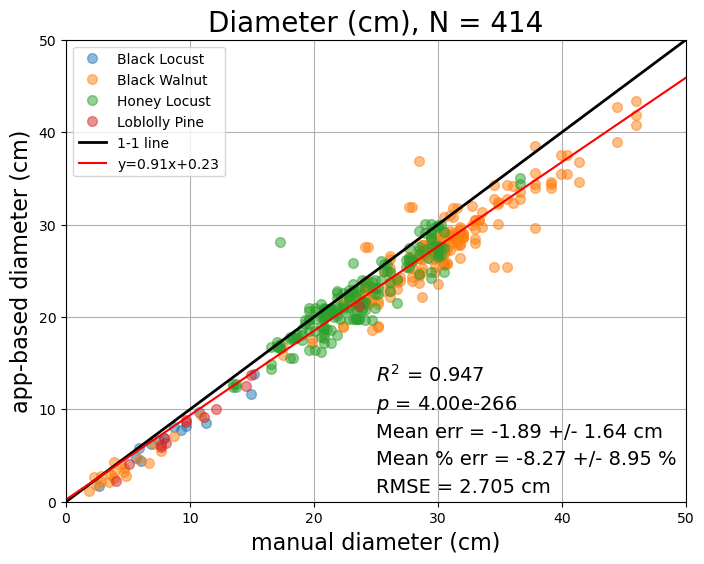

In [36]:
diam_all = all_data.copy().dropna()

# Diam linear regression grouped by species 

groups = diam_all.groupby('species')

# Plot
fig, ax = plt.subplots(figsize = (8,6))

for name, group in groups:
    ax.plot(group['manual'], group['app'], marker='o', linestyle='', ms=7, label=name, alpha = 0.5)
    
# Plot 1-1 line
ax.plot([0,300],[0,300],'k-', lw=2, label = '1-1 line')

# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(diam_all['manual'].astype(float), diam_all['app'].astype(float))

# Mean absolute error
mae = np.nanmean((diam_all['app'] - diam_all['manual']))
mae_std = np.nanstd(abs(diam_all['app'] - diam_all['manual']))
mape = np.nanmean(((diam_all['app'] - diam_all['manual']) / diam_all['manual'])) * 100
mape_std = np.nanstd(((diam_all['app'] - diam_all['manual']) / diam_all['manual'])) * 100
rmse = ((diam_all['app'] - diam_all['manual']) ** 2).mean() ** .5

# regression line 
line = slope*np.linspace(0,300)+ intercept
plt.plot(np.linspace(0,300), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.annotate("$R^2$ = {}".format(str(r_value**2)[:5]), [25,13], size = 14)
plt.annotate("$p$ = {:.2e}".format(p_value), [25,10], size = 14)
plt.annotate("Mean err = {} +/- {} cm".format(str(round(mae,5))[:5],str(round(mae_std,2))), [25,7], size = 14)
plt.annotate("Mean % err = {} +/- {} %".format(str(round(mape,5))[:5],str(round(mape_std,2))), [25,4], size = 14)
plt.annotate("RMSE = {} cm".format(str(round(rmse,5))[:5],), [25,1], size = 14)

ax.legend()
ax.set_xlim(0,50)
ax.set_ylim(0,50)
    
plt.xlabel("manual diameter (cm)", size = 16)
plt.ylabel("app-based diameter (cm)", size = 16)


titlestr = "Diameter (cm), N = {}".format(str(len(diam_all)))
plt.title(titlestr, size = 20)
plt.grid()
plt.show()

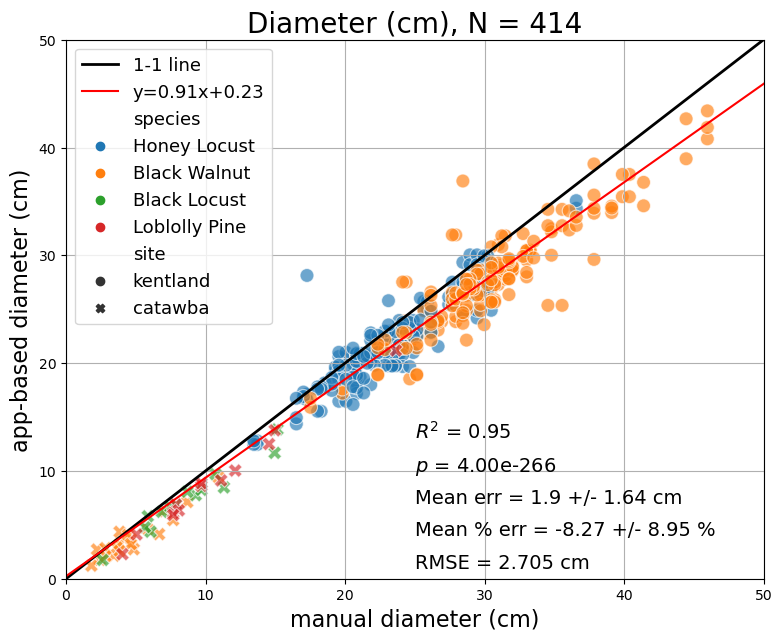

In [37]:
# Plot
fig, ax = plt.subplots(figsize = (9,7))

sns.scatterplot(data = diam_all, x = 'manual', y = 'app', 
                hue = 'species', style = 'site', s = 100, alpha = 0.65, ax = ax)

# Plot 1-1 line
ax.plot([0,300],[0,300],'k-', lw=2, label = '1-1 line')

# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(diam_all['manual'].astype(float), diam_all['app'].astype(float))

# Mean absolute error
mae = np.nanmean((diam_all['app'] - diam_all['manual']))
mae_std = np.nanstd(abs(diam_all['app'] - diam_all['manual']))
mape = np.nanmean(((diam_all['app'] - diam_all['manual']) / diam_all['manual'])) * 100
mape_std = np.nanstd(((diam_all['app'] - diam_all['manual']) / diam_all['manual'])) * 100
rmse = ((diam_all['app'] - diam_all['manual']) ** 2).mean() ** .5

# regression line 
line = slope*np.linspace(0,300)+ intercept
plt.plot(np.linspace(0,300), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.annotate("$R^2$ = {}".format(str(round(r_value**2,2))), [25,13], size = 14)
plt.annotate("$p$ = {:.2e}".format(p_value), [25,10], size = 14)
plt.annotate("Mean err = {} +/- {} cm".format(str(round(abs(mae),2)),str(round(mae_std,2))), [25,7], size = 14)
plt.annotate("Mean % err = {} +/- {} %".format(str(round(mape,2)),str(round(mape_std,2))), [25,4], size = 14)
plt.annotate("RMSE = {} cm".format(str(round(rmse,5))[:5],), [25,1], size = 14)

ax.legend(fontsize = 13)
ax.set_xlim(0,50)
ax.set_ylim(0,50)
    
plt.xlabel("manual diameter (cm)", size = 16)
plt.ylabel("app-based diameter (cm)", size = 16)


titlestr = "Diameter (cm), N = {}".format(str(len(diam_all)))
plt.title(titlestr, size = 20)
plt.grid()
plt.show()

In [38]:
def concordance_corr_coeff(x,y,correlation):
    numerator = 2 * correlation * np.nanstd(x) * np.nanstd(y)
    denom = np.nanstd(x)**2 + np.nanstd(y)**2  + (np.nanmean(x) - np.nanmean(y)) ** 2
    return numerator/denom

def intra_class_corr(x,y):
    N = len(x)
    x_bar = (1 / (2 * N)) * np.nansum(x+y)
    s_sq = (1 / (2 * N)) * ( np.nansum((x - x_bar)**2) + np.nansum((y - x_bar)**2) ) 
    ICC = (1 / (N * s_sq)) * np.nansum( (x-x_bar ) * (y - x_bar) )
    
    return ICC

In [39]:
print(concordance_corr_coeff(diam_all['app'],diam_all['manual'],r_value))
print(intra_class_corr(diam_all['app'],diam_all['manual']))

0.9454424858791449
0.9447000835522004


In [40]:
out_table_rows = []

for sp in diam_all['species'].unique():
    ddf = diam_all[diam_all['species']==sp]
    slope, intercept, r_value, p_value, std_err = stats.linregress(ddf['app'].astype(float), ddf['manual'].astype(float))
    cc = concordance_corr_coeff(ddf['app'], ddf['manual'], correlation = r_value)
    icc = intra_class_corr(ddf['app'],ddf['manual'])
    rmse = ((ddf['app'] - ddf['manual']) ** 2).mean() ** .5
    mean_error = (ddf['app']-ddf['manual']).mean()
    mpe = np.nanmean((ddf['app']-ddf['manual'])/ddf['manual'])*100
    rsq = r_value**2
    num_samples = len(ddf)
    print("======="*5)
    print(sp  + " N = {}".format(len(ddf)))
    print("Mean error = {}".format(mean_error))
    print("Mean Pct error = {}".format(mpe))
    print("R2 = {}".format(rsq))
    print("RMSE = {}".format(rmse))
    print("concordance correlation coeff = {}".format(cc))
    print("intraclass correlation coeff = {}".format(icc))
    
    statdf = pd.DataFrame([num_samples,mean_error,mpe,rmse,rsq,cc,icc])
    statdf.columns = [sp]
    statdf.index = ['N','ME','MPE','RMSE','$R^2$','$p_c$','$r$']
    out_table_rows.append(statdf)
    
#     print(stats.levene(ddf['manual'],ddf['app'], center= 'mean'))
#     print(stats.ttest_rel(ddf['manual'],ddf['app']))
#     print(stats.ttest_ind(ddf['manual'],ddf['app'], equal_var = False))
#     print(stats.wilcoxon(ddf['manual'],ddf['app']))

Honey Locust N = 180
Mean error = -1.3331588310029778
Mean Pct error = -5.504021958528081
R2 = 0.8413210979763669
RMSE = 2.181256476558439
concordance correlation coeff = 0.8735246022541252
intraclass correlation coeff = 0.8704646497753161
Black Walnut N = 207
Mean error = -2.4507043109365285
Mean Pct error = -9.619316393888449
R2 = 0.9493373185338015
RMSE = 3.1897503537685594
concordance correlation coeff = 0.935226457576409
intraclass correlation coeff = 0.9339639998219338
Black Locust N = 14
Mean error = -1.293292646448514
Mean Pct error = -15.42037494493922
R2 = 0.9506944745824281
RMSE = 1.5376073634281786
concordance correlation coeff = 0.8910274785930821
intraclass correlation coeff = 0.8866585129804169
Loblolly Pine N = 13
Mean error = -1.5775687524746873
Mean Pct error = -17.48794769465974
R2 = 0.9917727402364861
RMSE = 1.654860975158781
concordance correlation coeff = 0.9433509143233588
intraclass correlation coeff = 0.941854214481604


In [41]:
pd.concat(out_table_rows, axis = 1).T

,N,ME,MPE,RMSE,$R^2$,$p_c$,$r$
Honey Locust,180.0,-1.333159,-5.504022,2.181256,0.841321,0.873525,0.870465
Black Walnut,207.0,-2.450704,-9.619316,3.189750,0.949337,0.935226,0.933964
Black Locust,14.0,-1.293293,-15.420375,1.537607,0.950694,0.891027,0.886659
Loblolly Pine,13.0,-1.577569,-17.487948,1.654861,0.991773,0.943351,0.941854


In [42]:
pd.concat(out_table_rows, axis = 1).T.to_csv("../results/Table1.csv")

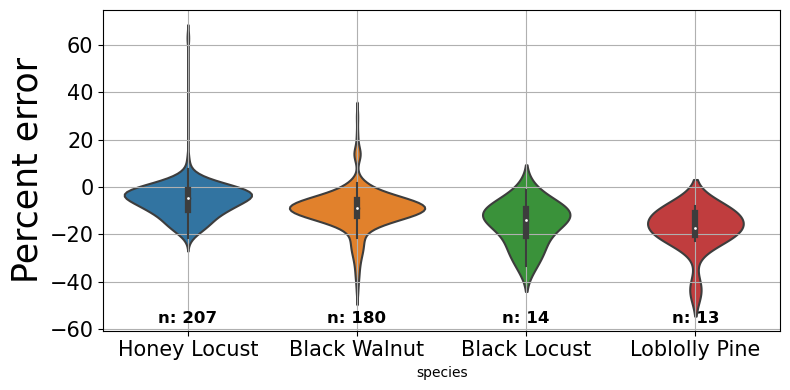

In [43]:
# Violin Plots 
diam_all['manual'] = diam_all['manual'].astype(float)
diam_all['app'] = diam_all['app'].astype(float)

diam_all['mae'] = diam_all['app'] - diam_all['manual']
diam_all['mpe'] = (diam_all['app'] - diam_all['manual']) / diam_all['manual'] * 100

# Boxplot of error 
plt.figure(figsize = (8,4))
ax = sns.violinplot(x="species", y="mpe", data=diam_all)
 
# Calculate number of obs per group & median to position labels
medians = diam_all.dropna().groupby(['species'])['mpe'].mean().values
nobs = diam_all['species'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
             - 57.5,
            nobs[tick],
            horizontalalignment='center',
            size='large',
            color='black',
            weight='semibold')
plt.ylabel("Percent error", size = 25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.grid() 

plt.tight_layout()

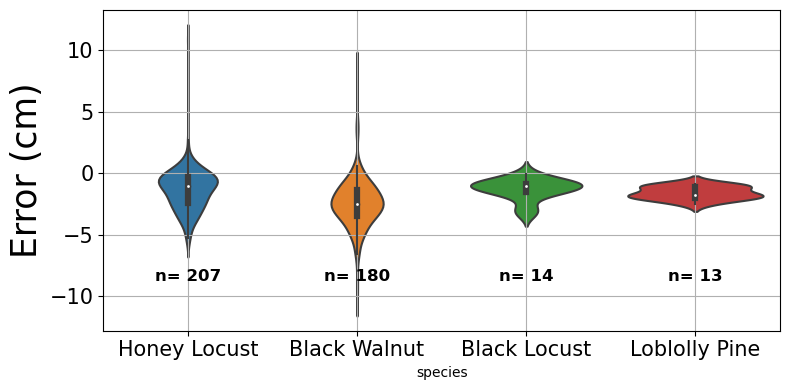

In [44]:
# Boxplot of error 
plt.figure(figsize = (8,4))
ax = sns.violinplot(x="species", y="mae", data=diam_all)
 
# Calculate number of obs per group & median to position labels
medians =diam_all.dropna().groupby(['species'])['mae'].mean().values
nobs = diam_all['species'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n= " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
             - 8.75,
            nobs[tick],
            horizontalalignment='center',
            size='large',
            color='black',
            weight='semibold')
plt.ylabel("Error (cm)", size = 25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.grid() 

plt.tight_layout()
plt.show()

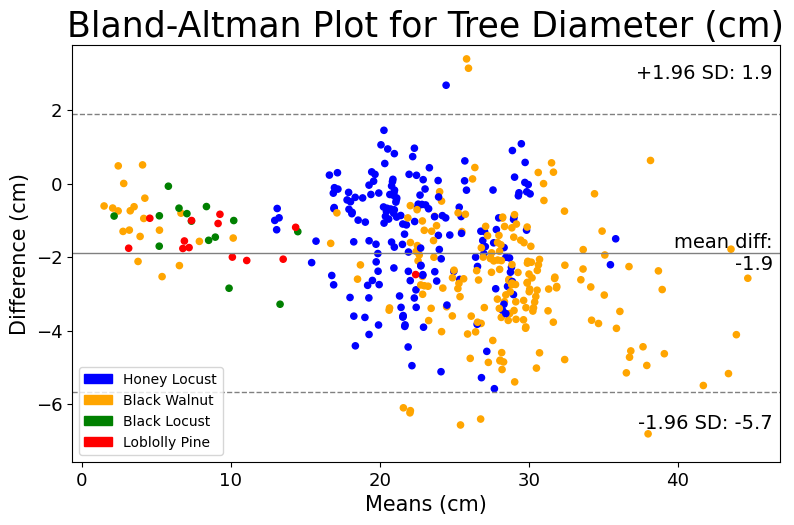

98.068 % of the data falls within 95% Diameter CI


In [45]:
# Bland Altman Plot 
diam_all['color'] = ""

diam_all.loc[diam_all['species'] == "Honey Locust", 'color'] = 'blue'
diam_all.loc[diam_all['species'] == "Black Walnut", 'color'] = 'orange'
diam_all.loc[diam_all['species'] == "Black Locust", 'color'] = 'green'
diam_all.loc[diam_all['species'] == "Loblolly Pine", 'color'] = 'red'

f, ax = plt.subplots(1, figsize = (8,5))

sm.graphics.mean_diff_plot(diam_all['app'], diam_all['manual'],  ax = ax, scatter_kwds = {"c": diam_all['color']})
plt.title("Bland-Altman Plot for Tree Diameter (cm)", size = 25)

hl_patch = mpatches.Patch(color='blue', label='Honey Locust')
bw_patch = mpatches.Patch(color='orange', label='Black Walnut')
bl_patch = mpatches.Patch(color='green', label='Black Locust')
lp_patch = mpatches.Patch(color='red', label='Loblolly Pine')

patches = [hl_patch, bw_patch,bl_patch,lp_patch]
plt.legend(handles=patches, loc = 'lower left')

plt.ylabel("Difference (cm)")
plt.xlabel("Means (cm)")
plt.show() 

# 8
print("{} % of the data falls within 95% Diameter CI".format(str(round((100 - ((8/len(diam_all)) * 100)),3))))


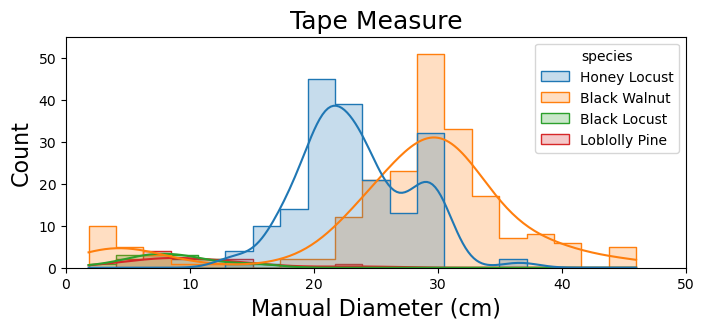

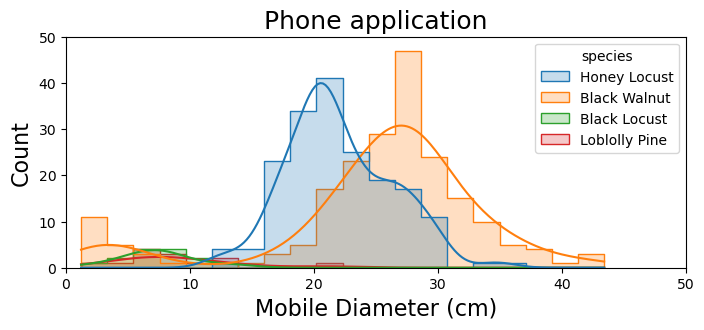

In [46]:
plt.figure(figsize = (8,3))
sns.histplot(diam_all, x="manual", hue="species", element="step", kde = True, bins = 20)
plt.xlim([0,50])
plt.ylim([0,55])
plt.title("Tape Measure", size = 18)
plt.xlabel("Manual Diameter (cm)", size = 16)
plt.ylabel("Count", size = 16)
plt.show()

plt.figure(figsize = (8,3))
sns.histplot(diam_all, x="app", hue="species", element="step", kde = True, bins = 20)
plt.xlim([0,50])
plt.ylim([0,50])
plt.title("Phone application", size = 18)
plt.xlabel("Mobile Diameter (cm)", size = 16)
plt.ylabel("Count", size = 16)
plt.show()


In [47]:
# Reformat to do a hist plot for each species 

man_sp_df = diam_all[['manual','species']]
app_sp_df = diam_all[['app','species']]

app_sp_df.columns = ['diameter','species']
app_sp_df['method'] = 'phone'
man_sp_df.columns = ['diameter','species']
man_sp_df['method'] = 'manual'

rfdf = pd.concat([app_sp_df,man_sp_df], axis = 0)

/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7844/2767483850.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_sp_df['method'] = 'phone'
/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7844/2767483850.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  man_sp_df['method'] = 'manual'


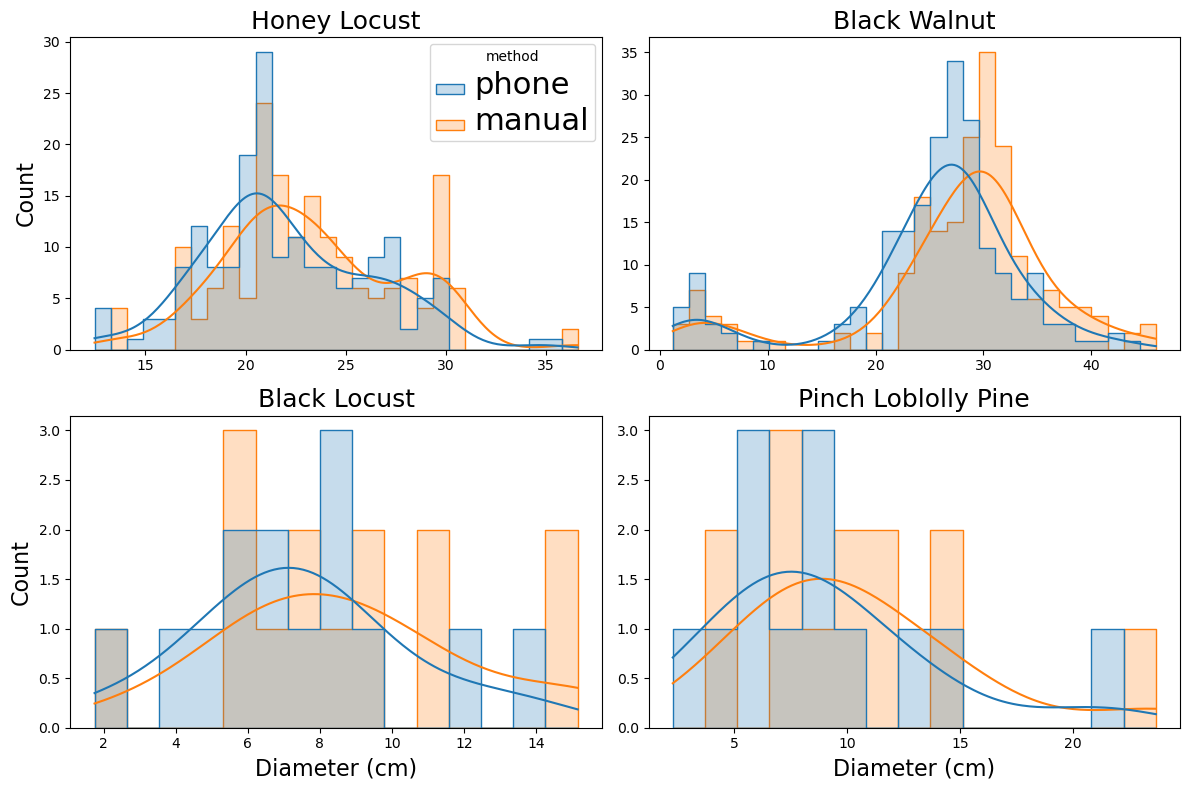

In [48]:
plt.figure(figsize = (12,8))

plt.subplot(221)
ax =sns.histplot(rfdf[rfdf['species'] == "Honey Locust"], x="diameter", hue="method", element="step", kde = True, bins = 30)
plt.title("Honey Locust", size = 18)
plt.xlabel("", size = 16)
plt.ylabel("Count", size = 16)
plt.setp(ax.get_legend().get_texts(), fontsize='22')

plt.subplot(222)
sns.histplot(rfdf[rfdf['species'] == "Black Walnut"], x="diameter", hue="method", element="step", kde = True, bins = 30, legend = None)
plt.title("Black Walnut", size = 18)
plt.xlabel("", size = 16)
plt.ylabel("", size = 16)

plt.subplot(223)
sns.histplot(rfdf[rfdf['species'] == "Black Locust"], x="diameter", hue="method", element="step", kde = True, bins = 15, legend = None)
plt.title("Black Locust", size = 18)
plt.xlabel("Diameter (cm)", size = 16)
plt.ylabel("Count", size = 16)

plt.subplot(224)
sns.histplot(rfdf[rfdf['species'] == "Loblolly Pine"], x="diameter", hue="method", element="step", kde = True, bins = 15, legend = None)
plt.title("Pinch Loblolly Pine", size = 18)
plt.xlabel("Diameter (cm)", size = 16)
plt.ylabel("", size = 16)

plt.tight_layout()
plt.show()


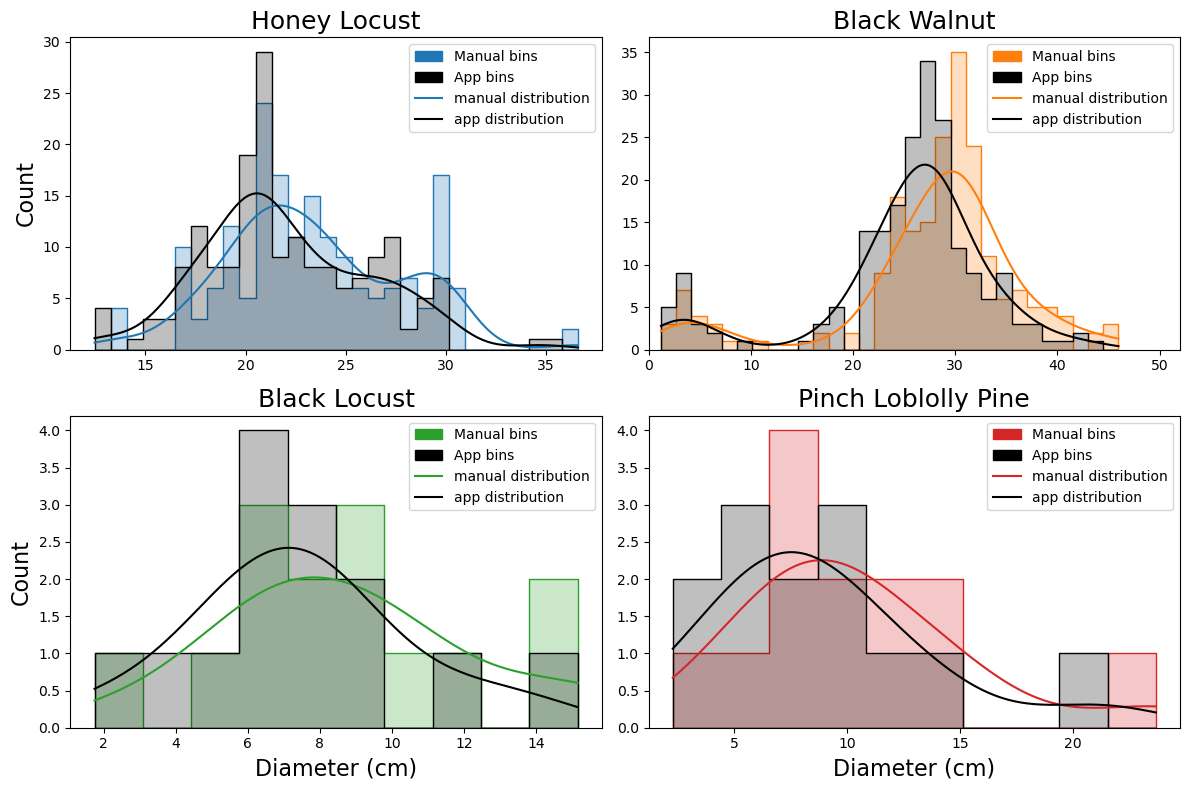

In [49]:
plt.figure(figsize = (12,8))

hl_patch = mpatches.Patch(color='C0', label='Manual bins')
hl_patch2 = mpatches.Patch(color='black', label='App bins')
hl_line = Line2D([0], [0], label='manual distribution', color='C0')
hl_line2 = Line2D([0], [0], label='app distribution', color='black')

bw_patch = mpatches.Patch(color='C1', label='Manual bins')
bw_patch2 = mpatches.Patch(color='black', label='App bins')
bw_line = Line2D([0], [0], label='manual distribution', color='C1')
bw_line2 = Line2D([0], [0], label='app distribution', color='black')

bl_patch = mpatches.Patch(color='C2', label='Manual bins')
bl_patch2 = mpatches.Patch(color='black', label='App bins')
bl_line = Line2D([0], [0], label='manual distribution', color='C2')
bl_line2 = Line2D([0], [0], label='app distribution', color='black')

lp_patch = mpatches.Patch(color='C3', label='Manual bins')
lp_patch2 = mpatches.Patch(color='black', label='App bins')
lp_line = Line2D([0], [0], label='manual distribution', color='C3')
lp_line2 = Line2D([0], [0], label='app distribution', color='black')

plt.subplot(221)
ax =sns.histplot(rfdf[rfdf['species'] == "Honey Locust"], x="diameter", hue="method",palette=["black", "C0"], element="step", kde = True, bins = 30)
plt.title("Honey Locust", size = 18)
plt.xlabel("", size = 16)
plt.ylabel("Count", size = 16)
plt.legend(handles=[hl_patch, hl_patch2, hl_line, hl_line2])

plt.subplot(222)
sns.histplot(rfdf[rfdf['species'] == "Black Walnut"], x="diameter", hue="method",palette=["black", "C1"], element="step", kde = True, bins = 30, legend = None)
plt.title("Black Walnut", size = 18)
plt.xlabel("", size = 16)
plt.ylabel("", size = 16)
plt.xlim(0,52)
plt.legend(handles=[bw_patch, bw_patch2, bw_line, bw_line2])

plt.subplot(223)
sns.histplot(rfdf[rfdf['species'] == "Black Locust"], x="diameter", hue="method",palette=["black", "C2"], element="step", kde = True, bins = 10, legend = None)
plt.title("Black Locust", size = 18)
plt.xlabel("Diameter (cm)", size = 16)
plt.ylabel("Count", size = 16)
plt.legend(handles=[bl_patch, bl_patch2, bl_line, bl_line2])

plt.subplot(224)
sns.histplot(rfdf[rfdf['species'] == "Loblolly Pine"], x="diameter", hue="method",palette=["black", "C3"], element="step", kde = True, bins = 10, legend = None)
plt.title("Pinch Loblolly Pine", size = 18)
plt.xlabel("Diameter (cm)", size = 16)
plt.ylabel("", size = 16)
plt.legend(handles=[lp_patch, lp_patch2, lp_line, lp_line2])
plt.tight_layout()
plt.show()
